# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на тарифы Ultra и Smart. В данном проекте построим модель для задачи классификации с максимально большим значением *accuracy*, которая выберет подходящий тариф. 

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

### Импортируем необходимые библиотеки

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

### Читаем csv файл, выводим данные на экран, смотрим общую информацию

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info() 
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


После выгрузки данных мы увидели, что пропуски отсутствуют, данные представлены в корректных типах и пригодны к дальнейшему исследованию.

## Разобьем данные на выборки

Так как у нас нет отдельной тестовой выборки разобьем данные на три части: обучающую, валидационную и тестовую. Данные разобьем  в соотношении 3:1:1 соответственно.

In [4]:
features = df.drop(['is_ultra'], axis=1) # извлекаем признаки
target = df['is_ultra'] # извлекаем целевой признак

Сначала выделим 60% данных под обучение модели

In [5]:
features_train, features_unit, target_train, target_unit = train_test_split(
    features, target, test_size=0.4, random_state=12345)

Осавшиеся 40% данных разделим пополам на валидационную и тестовую выборки

In [6]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_unit, target_unit, test_size=0.5, random_state=12345)

Изучим размеры выборок.

In [7]:
features_train.shape # признаки обучающей выборки

(1928, 4)

In [8]:
features_valid.shape # признаки валидационной выборки

(643, 4)

In [9]:
features_test.shape # признаки тестовой выборки

(643, 4)

## Исследуем модели

Метрикой качества наших моделей выбираем — accuracy,так как чем выше точность классификации, тем точнее мы можем определить на какой тариф перейдет определенный пользователь, в случае смены тарифа. При обучении модели будем изменять гиперпарметры, для нахождения наилучшей модели.

### Модель для классификации деревом решений

In [10]:
%%time
list_depth, list_accuracy = [], []
best_model_tree = None
best_result = 0
best_depth = 0
for depth in range(1, 30):
    model_tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) # обучим модель с заданной глубиной дерева
    model_tree.fit(features_train, target_train) # обучение  модели тестовыми данными 
    predictions = model_tree.predict(features_valid) # получите предсказания модели
    result = accuracy_score(target_valid, predictions) # посчитаем качество модели на валидационной выборке
    if result > best_result: # если качество модели наилучшее сохраним параметры модели
        best_model_tree = model_tree # сохраним наилучшую модель
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth # сохраним глубину наилучшуей модели    
    list_depth.append(depth)
    list_accuracy.append(result)        
print("Accuracy лучшей модели:", best_result, 
      "Максимальная глубина:", best_depth)

Accuracy лучшей модели: 0.7853810264385692 Максимальная глубина: 3
CPU times: user 307 ms, sys: 0 ns, total: 307 ms
Wall time: 307 ms


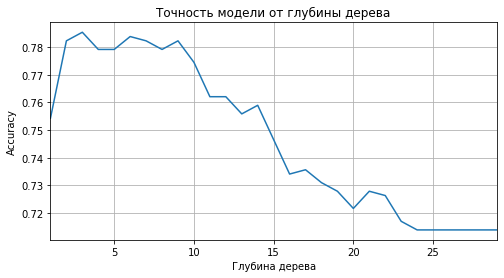

In [11]:
depth_accuracy = pd.Series(list_accuracy, list_depth)
plt.figure(figsize=(8,4))
depth_accuracy.plot(grid=True)
plt.title('Точность модели от глубины дерева')
plt.xlabel("Глубина дерева")
plt.ylabel("Accuracy")
plt.show()

Максимальное значение Accuracy при глубине дерева до 10, так как когда большая глубина происходит переобучение модели и точность падает.

### Модель для классификации алгоритмом - "случайный лес"

In [21]:
%%time
best_est = 0
best_depth = 0
best_model_forest = None
best_result = 0
for est in range(1,30,2):
    for depth in range(1,30,2):
        model_forest = RandomForestClassifier(random_state=12345, 
                                              n_estimators=est, 
                                              max_depth=depth) # обучим модель с заданным количеством деревьев и глубиной дерева
        model_forest.fit(features_train,target_train) # обучим модель на тренировочной выборке
    
        result = model_forest.score(features_valid, target_valid) # посчитаем качество модели на валидационной выборке
        if result > best_result:
            best_model_forest = model_forest # сохраним наилучшую модель
            best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
            best_est = est # сохраним глубину наилучшуей модели
            best_depth = depth # сохраним глубину наилучшуей модели
            
                    
print("Accuracy модели:", best_result,
      "Количество деревьев наилучшей модели:", best_est,
      "Максимальная глубина:", best_depth)

Accuracy модели: 0.8040435458786936 Количество деревьев наилучшей модели: 27 Максимальная глубина: 7
CPU times: user 13.7 s, sys: 47.1 ms, total: 13.7 s
Wall time: 13.8 s


### Модель для классификации алгоритмом — логистической регрессии.

In [22]:
%%time
model_log = LogisticRegression(random_state=12345)  # инициализируем модель логистической регрессии 
model_log.fit(features_train, target_train) # обучим модель на тренировочной выборке
result = model_log.score(features_valid,target_valid) # получим метрику качества модели на валидационной выборке

print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7589424572317263
CPU times: user 17.6 ms, sys: 3.97 ms, total: 21.6 ms
Wall time: 19.5 ms


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Вывод исследования моделей.

Изучив модели можем сделать вывод, что случайный лес дает самое большое значение Accuracy = 0.8040435458786936.Посмотрели на влияние основного гиперпараметра решающего дерева — max_depth и увидели, что большая глубина дерева приводит к переобучению.  

## Проверка моделей на тестовой выборке

In [14]:
result = best_model_forest.score(features_test, target_test) # посчитаем качество модели на тестовой выборке
print('best_model_forest',result)
result = best_model_tree.score(features_test, target_test) # посчитаем качество модели на тестовой выборке
print('best_model_tree',result)
result = model_log.score(features_test, target_test) # посчитаем качество модели на тестовой выборке
print('model_log',result)

best_model_forest 0.8055987558320373
best_model_tree 0.7791601866251944
model_log 0.7402799377916018


Проверка на тестовой выборке так же показала, что случайный лес дает самое большое значение Accuracy.

## Проверка модели на адекватность

In [15]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Так как наши данные по классам не сбалансированы, что видно выше, сбалансируем данные по классу с минимальным количеством экземпляров.

In [16]:
g = df.groupby('is_ultra')
df_adequacy = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
df_adequacy['is_ultra'].value_counts()

1    985
0    985
Name: is_ultra, dtype: int64

Сбалансировав данные можно представить случайную  модель ответы которой не связаны с правильными ответами, поэтому вероятность угадать 1 равна 50% (так же и для 0). Accuracy будет равна 0.5.

Теперь сравним качество нашей лучшей модели best_model_forest со случайной.

In [17]:
features_ad = df_adequacy.drop(['is_ultra'], axis=1) # извлекаем признаки
target_ad = df_adequacy['is_ultra'] # извлекаем целевой признак

In [18]:
result = best_model_forest.score(features_ad, target_ad) # посчитайте качество модели на валидационной выборке
print('best_model_forest',result)

best_model_forest 0.7543147208121828


Видим, что наша модель дает результат Accuracy лучше чем случайная, значит можно утверждать,что наша модель адекватная.